<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Clipping%20Raster%20In%20R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clip Raster in R
#### https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/crop-raster-data-in-r/

In [1]:
# load the raster and rgdal libraries
install.packages("raster")
install.packages("rgdal")
install.packages("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘Rcpp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘rgdal’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# install.packages('sf')
# install.packages('exactextractr')
# install.packages("DBI")
# install.packages("RSQLite")
# install.packages("RPostgreSQL")

In [3]:
library(ggplot2)
# library(sf)
library(magrittr)
library(data.table)
library(raster)
# library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

Loading required package: sp


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [4]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=757a4735af5545895f22bd7c187cad7f&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbnd6eFpINTlOVUFGQzVfdXhGRUplcXFNM1VQYV91c2tsMVIwMkhZeEhSdHFuRll4YVBqckpTa04wTzN1Skd2QSIsInN0YXRlIjoiNzU3YTQ3MzVhZjU1NDU4OTVmMjJiZDdjMTg3Y2FkN2YifQ==


In [5]:
dir.create('/content/Maui')

In [6]:
# extract the data from drive and bring it to local memory
#  Island Path LS 3x, CCAP 1x

# MAUI

# LS 2000 https://drive.google.com/file/d/1bjng9xUS5z5scldDwptDkgD2dGuFkrOm/view?usp=drive_link
drive_download(file = as_id('1bjng9xUS5z5scldDwptDkgD2dGuFkrOm'), path =  '/content/Maui/Maui_2000.tif', overwrite = FALSE)
# LS 2001 https://drive.google.com/file/d/1SGGQCTPmYC8XiVi5fmGNbrj5wdH07tSR/view?usp=drive_link
drive_download(file = as_id('1SGGQCTPmYC8XiVi5fmGNbrj5wdH07tSR'), path =  '/content/Maui/Maui_2001.tif', overwrite = FALSE)
# LS 2002 https://drive.google.com/file/d/1SNXqLgz8CHuHOscNGa983SWGgtueNTWy/view?usp=drive_link
drive_download(file = as_id('1SNXqLgz8CHuHOscNGa983SWGgtueNTWy'), path =  '/content/Maui/Maui_2002.tif', overwrite = FALSE)

# CCAP 2005 https://drive.google.com/file/d/1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9/view?usp=drive_link
drive_download(file = as_id('1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9'), path =  '/content/Maui/Maui_CCAP.tif', overwrite = FALSE)

File downloaded:

• Maui_2000_elevation.tif <id: 1bjng9xUS5z5scldDwptDkgD2dGuFkrOm>

Saved locally as:

• /content/Maui/Maui_2000.tif

File downloaded:

• Maui_2001_elevation.tif <id: 1SGGQCTPmYC8XiVi5fmGNbrj5wdH07tSR>

Saved locally as:

• /content/Maui/Maui_2001.tif

File downloaded:

• Maui_2002_elevation.tif <id: 1SNXqLgz8CHuHOscNGa983SWGgtueNTWy>

Saved locally as:

• /content/Maui/Maui_2002.tif

File downloaded:

• hi_maui_2005_ccap_hr_land_cover.img <id: 1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9>

Saved locally as:

• /content/Maui/Maui_CCAP.tif



In [7]:
ccap_raster <- stack('/content/Maui/Maui_CCAP.tif')
ls_2000 <- stack('/content/Maui/Maui_2000.tif')
ls_2001 <- stack('/content/Maui/Maui_2001.tif')
ls_2002 <- stack('/content/Maui/Maui_2002.tif')
ls_stack <- c(ls_2000, ls_2001, ls_2002)

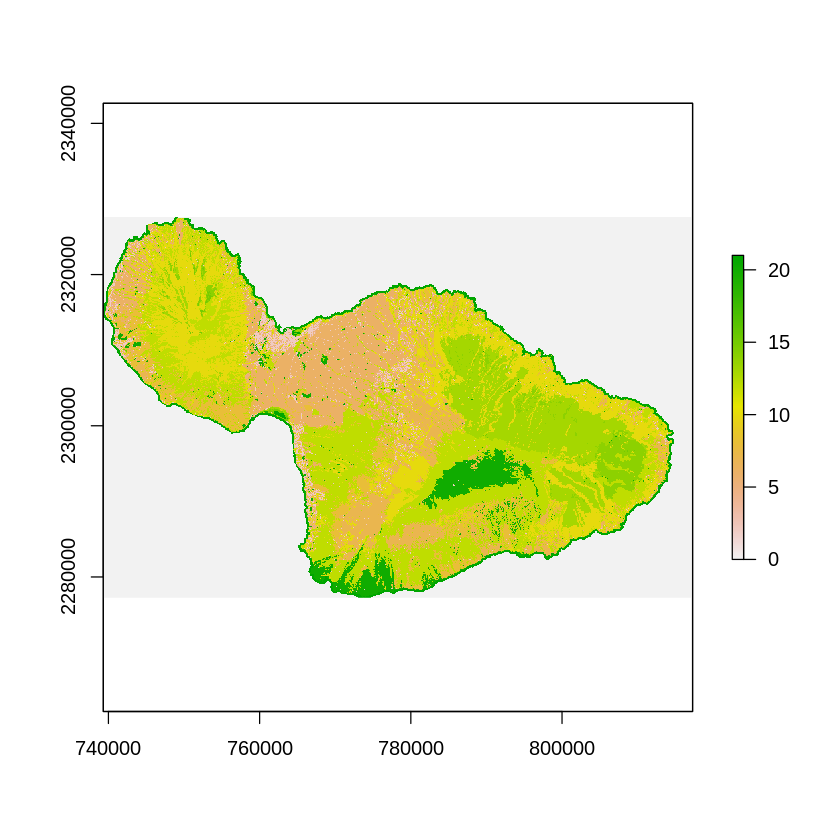

In [8]:
ccap_raster%>% plot

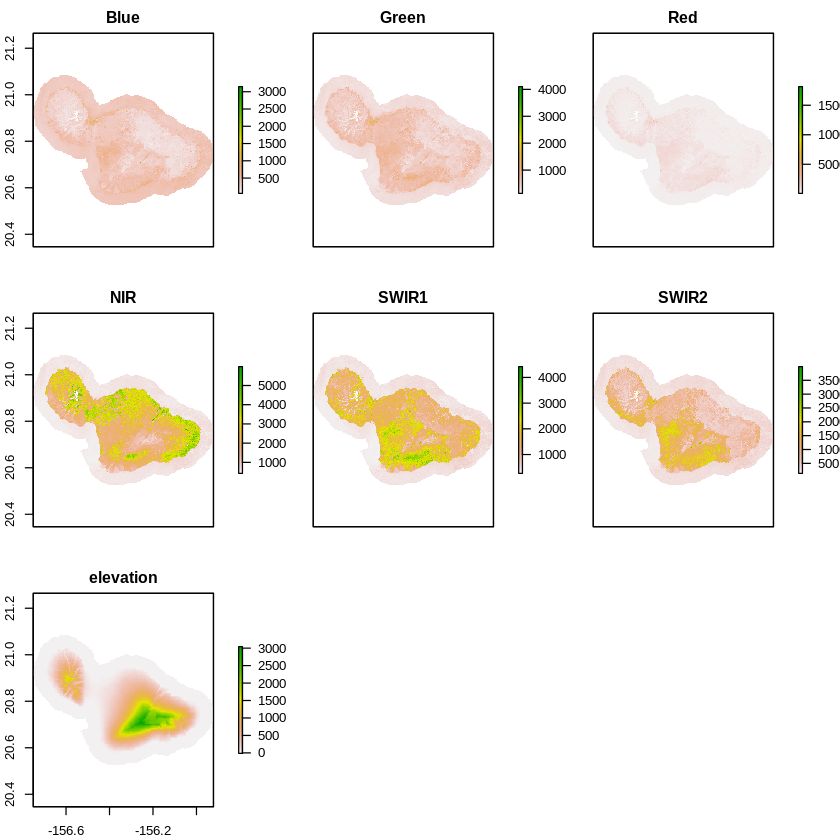

In [9]:
ls_2000%>% plot

In [12]:
# Stack all three layers into one
stack_all <- stack(ls_2000, ls_2001, ls_2002)

# Define the output file path
output_path <- '/content/Maui/Maui_2000_2002.tif'

# Write the stacked raster to a new .tif file
writeRaster(stack_all, filename = output_path, format = 'GTiff')

# Check the new file
stack_all

class      : RasterStack 
dimensions : 2079, 3076, 6395004, 21  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -156.7507, -155.9218, 20.52525, 21.08553  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue.1, Green.1, Red.1, NIR.1, SWIR1.1, SWIR2.1, elevation.1, Blue.2, Green.2, Red.2, NIR.2, SWIR1.2, SWIR2.2, elevation.2, Blue.3, ... 


In [13]:
stack_all

class      : RasterStack 
dimensions : 2079, 3076, 6395004, 21  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -156.7507, -155.9218, 20.52525, 21.08553  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue.1, Green.1, Red.1, NIR.1, SWIR1.1, SWIR2.1, elevation.1, Blue.2, Green.2, Red.2, NIR.2, SWIR1.2, SWIR2.2, elevation.2, Blue.3, ... 


In [14]:
nrow(ccap_raster)
ncol(ccap_raster)
nlayers(ccap_raster)
dim(ccap_raster)

[1] 20986

[1] 32476

[1] 1

[1] 20986 32476     1

In [15]:
nrow(stack_all)
ncol(stack_all)
nlayers(stack_all)
dim(stack_all)

[1] 2079

[1] 3076

[1] 21

[1] 2079 3076   21

In [ ]:
stack_all%>% plot

In [16]:
ls_raster_extended <- extend(stack_all, projectExtent(ccap_raster, stack_all), value=NA)

In [17]:
ls_raster_extended

class      : RasterStack 
dimensions : 2079, 3076, 6395004, 21  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -156.7507, -155.9218, 20.52525, 21.08553  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue.1, Green.1, Red.1, NIR.1, SWIR1.1, SWIR2.1, elevation.1, Blue.2, Green.2, Red.2, NIR.2, SWIR1.2, SWIR2.2, elevation.2, Blue.3, ... 


In [18]:
y_end <- c(seq(1,ccap_raster %>% nrow,512),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,512),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)

In [19]:
new_folder_path <- "/content/Maui_Images"
new_folder_path2 <- "/content/Maui_Labels"
# Use dir.create to create the new folder
dir.create(new_folder_path, showWarnings = FALSE)

# Check if the folder was created successfully
if (file.exists(new_folder_path)) {
  cat("Folder created:", new_folder_path, "\n")
} else {
  cat("Failed to create folder:", new_folder_path, "\n")
}


# Use dir.create to create the new folder
dir.create(new_folder_path2, showWarnings = FALSE)
# Check if the folder was created successfully
if (file.exists(new_folder_path2)) {
  cat("Folder created:", new_folder_path2, "\n")
} else {
  cat("Failed to create folder:", new_folder_path2, "\n")
}

Folder created: /content/Maui_Images 
Folder created: /content/Maui_Labels 


In [20]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=512 | ncol != 512){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(ccap_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(ccap_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(ccap_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(ccap_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    ccap_cropped_raster <- crop(ccap_raster, e)

    nrow <- nrow(ccap_cropped_raster)
    ncol <- ncol(ccap_cropped_raster)


    # print(dim(ccap_cropped_raster))
    if(i>1000){return('failed to converge')}
    }

  ls_cropped_raster <- crop(ls_raster_extended, projectExtent(ccap_cropped_raster,stack_all))

  ls_resampled_raster <- projectRaster(ls_cropped_raster,ccap_cropped_raster)
  print(ls_resampled_raster)
  pixel_table <- (table(values(ccap_cropped_raster))/ncell(ccap_cropped_raster)) %>% data.table

  names(pixel_table) <- c('label','percent')

  out_dt <- data.table(extract_grid[x,],xmin = xmin,xmax =xmax,ymin= ymin,ymax, pixel_table)

  if(ls_resampled_raster %>% nrow ==512 & ls_resampled_raster %>% ncol ==512 & ccap_cropped_raster%>% nrow ==512 & ccap_cropped_raster%>% ncol ==512){
    ls_resampled_raster %>%
    writeRaster(., paste("/content/Maui_Images/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)

    ccap_cropped_raster %>%
    writeRaster(., paste("/content/Maui_Labels/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  }else(print('uh oh'))

  return(out_dt)
})
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/Maui_2000_2002.csv") # /content/Maui10/


In [ ]:
zip(zipfile = '/content/Maui_Images_2000_2002.zip', files = c("/content/Maui_Images"))
zip(zipfile = "/content/Maui_Labels_2000_2002.zip", files = c("/content/Maui_Labels"))


In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'big-passage-402400'
!gcloud config set project {project_id}

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

In [ ]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "datahub_bucket"  # or a location like "my-bucket/path/to/mount"
local_path = f"001_{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

In [ ]:
# Then you can access it like a local path.
!ls -lh {local_path}

In [ ]:
zip(zipfile = '/content/Maui_Images_2000_2002.zip', files = c("/content/Maui_Images"))
zip(zipfile = "/content/Maui_Labels_2000_2002.zip", files = c("/content/Maui_Labels"))

In [ ]:
!mkdir -p /content/001_datahub_bucket/Islands/Maui_2000_2002
!mkdir -p /content/001_datahub_bucket/Islands/Maui_2000_2002/Images
!mkdir -p /content/001_datahub_bucket/Islands/Maui_2000_2002/Labels

In [ ]:
gcloud init
!gsutil cp /content/Maui_Images_2000_2002.zip gs://content/001_datahub_bucket/Islands/Maui_2000_2002/Images/


In [ ]:
sourece_img = '/content/Maui_Images'
goto_img_location = '/content/001_datahub_bucket/Islands/Maui_2000_2002/Images'
shutil.copy(sourece_img, goto_img_location)



In [ ]:
# Island_Image_Clipped Export folder: https://drive.google.com/drive/folders/1ZViSMmF1BS5rgHiyy2EIl2EnfdsKv96F?usp=drive_link
drive_upload(media = "/content/Lanai/Labels.zip", path = as_id("1ZViSMmF1BS5rgHiyy2EIl2EnfdsKv96F"))
drive_upload(media = "/content/Lanai/Images.zip", path = as_id("1ZViSMmF1BS5rgHiyy2EIl2EnfdsKv96F"))
drive_upload(media = "/content/Lanai_2000_2002.csv", path = as_id("1ZViSMmF1BS5rgHiyy2EIl2EnfdsKv96F"))